```{raw} jupyter
<div id="qe-notebook-header" align="right" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" width="250px" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>
```

# {index}`Cake Eating V: The Endogenous Grid Method <single: Cake Eating V: The Endogenous Grid Method>`

```{contents} Contents
:depth: 2
```


## Overview

Previously, we solved the stochastic cake eating problem using

1. {doc}`value function iteration <cake_eating_stochastic>`
1. {doc}`Euler equation based time iteration <cake_eating_time_iter>`

We found time iteration to be significantly more accurate and efficient.

In this lecture, we'll look at a clever twist on time iteration called the **endogenous grid method** (EGM).

EGM is a numerical method for implementing policy iteration invented by [Chris Carroll](https://econ.jhu.edu/directory/christopher-carroll/).

The original reference is {cite}`Carroll2006`.

For now we will focus on a clean and simple implementation of EGM that stays
close to the underlying mathematics.

Then, in {doc}`the next lecture <cake_eating_egm_jax>`, we will construct a fully vectorized and parallelized version of EGM based on JAX.

Let's start with some standard imports:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import quantecon as qe

## Key Idea

First we remind ourselves of the theory and then we turn to numerical methods.

### Theory

We work with the model set out in {doc}`cake_eating_time_iter`, following the same terminology and notation.

The Euler equation is

```{math}
:label: egm_euler

(u'\circ \sigma^*)(x)
= \beta \int (u'\circ \sigma^*)(f(x - \sigma^*(x)) z) f'(x - \sigma^*(x)) z \phi(dz)
```

As we saw, the Coleman-Reffett operator is a nonlinear operator $K$ engineered so that $\sigma^*$ is a fixed point of $K$.

It takes as its argument a continuous strictly increasing consumption policy $\sigma \in \Sigma$.

It returns a new function $K \sigma$,  where $(K \sigma)(x)$ is the $c \in (0, \infty)$ that solves

```{math}
:label: egm_coledef

u'(c)
= \beta \int (u' \circ \sigma) (f(x - c) z ) f'(x - c) z \phi(dz)
```

### Exogenous Grid

As discussed in {doc}`cake_eating_time_iter`, to implement the method on a
computer, we need numerical approximation.

In particular, we represent a policy function by a set of values on a finite grid.

The function itself is reconstructed from this representation when necessary,
using interpolation or some other method.

Our {doc}`previous strategy <cake_eating_time_iter>` for obtaining a finite representation of an updated consumption policy was to

* fix a grid of income points $\{x_i\}$
* calculate the consumption value $c_i$ corresponding to each $x_i$ using
  {eq}`egm_coledef` and a root-finding routine

Each $c_i$ is then interpreted as the value of the function $K \sigma$ at $x_i$.

Thus, with the pairs $\{(x_i, c_i)\}$ in hand, we can reconstruct $K \sigma$ via approximation.

Iteration then continues...


### Endogenous Grid

The method discussed above requires a root-finding routine to find the
$c_i$ corresponding to a given income value $x_i$.

Root-finding is costly because it typically involves a significant number of
function evaluations.

As pointed out by Carroll {cite}`Carroll2006`, we can avoid this step if
$x_i$ is chosen endogenously.

The only assumption required is that $u'$ is invertible on $(0, \infty)$.

Let $(u')^{-1}$ be the inverse function of $u'$.

The idea is this:

* First, we fix an *exogenous* grid $\{s_i\}$ for savings ($s = x - c$).
* Then we obtain  $c_i$ via

```{math}
:label: egm_getc

c_i =
(u')^{-1}
\left\{
    \beta \int (u' \circ \sigma) (f(s_i) z ) \, f'(s_i) \, z \, \phi(dz)
\right\}
```

* Finally, for each $c_i$ we set $x_i = c_i + s_i$.

Importantly, each $(x_i, c_i)$ pair constructed in this manner satisfies {eq}`egm_coledef`.

With the points $\{x_i, c_i\}$ in hand, we can reconstruct $K \sigma$ via approximation as before.

The name EGM comes from the fact that the grid $\{x_i\}$ is determined **endogenously**.


## Implementation

As in {doc}`cake_eating_time_iter`, we will start with a simple setting where

* $u(c) = \ln c$,
* the function $f$ has a Cobb-Douglas specification, and
* the shocks are lognormal.

This will allow us to make comparisons with the analytical solutions.

In [2]:
def v_star(x, α, β, μ):
    """
    True value function
    """
    c1 = np.log(1 - α * β) / (1 - β)
    c2 = (μ + α * np.log(α * β)) / (1 - α)
    c3 = 1 / (1 - β)
    c4 = 1 / (1 - α * β)
    return c1 + c2 * (c3 - c4) + c4 * np.log(x)

def σ_star(x, α, β):
    """
    True optimal policy
    """
    return (1 - α * β) * x

We reuse the `Model` structure from {doc}`cake_eating_time_iter`.

In [3]:
from typing import NamedTuple, Callable

class Model(NamedTuple):
    u: Callable           # utility function
    f: Callable           # production function
    β: float              # discount factor
    μ: float              # shock location parameter
    ν: float              # shock scale parameter
    s_grid: np.ndarray    # exogenous savings grid
    shocks: np.ndarray    # shock draws
    α: float              # production function parameter
    u_prime: Callable     # derivative of utility
    f_prime: Callable     # derivative of production
    u_prime_inv: Callable # inverse of u_prime


def create_model(u: Callable,
                 f: Callable,
                 β: float = 0.96,
                 μ: float = 0.0,
                 ν: float = 0.1,
                 grid_max: float = 4.0,
                 grid_size: int = 120,
                 shock_size: int = 250,
                 seed: int = 1234,
                 α: float = 0.4,
                 u_prime: Callable = None,
                 f_prime: Callable = None,
                 u_prime_inv: Callable = None) -> Model:
    """
    Creates an instance of the cake eating model.
    """
    # Set up exogenous savings grid
    s_grid = np.linspace(1e-4, grid_max, grid_size)

    # Store shocks (with a seed, so results are reproducible)
    np.random.seed(seed)
    shocks = np.exp(μ + ν * np.random.randn(shock_size))

    return Model(u, f, β, μ, ν, s_grid, shocks, α, u_prime, f_prime, u_prime_inv)

### The Operator

Here's an implementation of $K$ using EGM as described above.

In [4]:
def K(
        c_in: np.ndarray,   # Consumption values on the endogenous grid
        x_in: np.ndarray,   # Current endogenous grid
        model: Model        # Model specification
    ):
    """
    An implementation of the Coleman-Reffett operator using EGM.

    """

    # Simplify names
    u, f, β, μ, ν, s_grid, shocks, α, u_prime, f_prime, u_prime_inv = model

    # Linear interpolation of policy on the endogenous grid
    σ = lambda x: np.interp(x, x_in, c_in)

    # Allocate memory for new consumption array
    c_out = np.empty_like(s_grid)

    # Solve for updated consumption value
    for i, s in enumerate(s_grid):
        vals = u_prime(σ(f(s, α) * shocks)) * f_prime(s, α) * shocks
        c_out[i] = u_prime_inv(β * np.mean(vals))

    # Determine corresponding endogenous grid
    x_out = s_grid + c_out        # x_i = s_i + c_i

    return c_out, x_out

Note the lack of any root-finding algorithm.

```{note}
The routine is still not particularly fast because we are using pure Python loops.

But in the next lecture ({doc}`cake_eating_egm_jax`) we will use a fully vectorized and efficient solution.
```

### Testing

First we create an instance.

In [5]:
# Define utility and production functions with derivatives
u = lambda c: np.log(c)
u_prime = lambda c: 1 / c
u_prime_inv = lambda x: 1 / x
f = lambda k, α: k**α
f_prime = lambda k, α: α * k**(α - 1)

model = create_model(u=u, f=f, u_prime=u_prime,
                     f_prime=f_prime, u_prime_inv=u_prime_inv)
s_grid = model.s_grid

Here's our solver routine:

In [6]:
def solve_model_time_iter(model: Model,
                          c_init: np.ndarray,
                          x_init: np.ndarray,
                          tol: float = 1e-5,
                          max_iter: int = 1000,
                          verbose: bool = True):
    """
    Solve the model using time iteration with EGM.
    """
    c, x = c_init, x_init
    error = tol + 1
    i = 0

    while error > tol and i < max_iter:
        c_new, x_new = K(c, x, model)
        error = np.max(np.abs(c_new - c))
        c, x = c_new, x_new
        i += 1
        if verbose:
            print(f"Iteration {i}, error = {error}")

    if i == max_iter:
        print("Warning: maximum iterations reached")

    return c, x

Let's call it:

In [7]:
c_init = np.copy(s_grid)
x_init = s_grid + c_init
c, x = solve_model_time_iter(model, c_init, x_init)

Iteration 1, error = 1.208333333333333
Iteration 2, error = 0.6834464555052788
Iteration 3, error = 0.3126351338414741
Iteration 4, error = 0.12905177785629984
Iteration 5, error = 0.05099394329538409
Iteration 6, error = 0.01980055511172729
Iteration 7, error = 0.007636088144566955
Iteration 8, error = 0.002937098891578671
Iteration 9, error = 0.0011285611196765188
Iteration 10, error = 0.00043347299641638415
Iteration 11, error = 0.00016646919532892213
Iteration 12, error = 6.392646634978405e-05
Iteration 13, error = 2.4548101555943447e-05
Iteration 14, error = 9.426520908739633e-06


Here is a plot of the resulting policy, compared with the true policy:

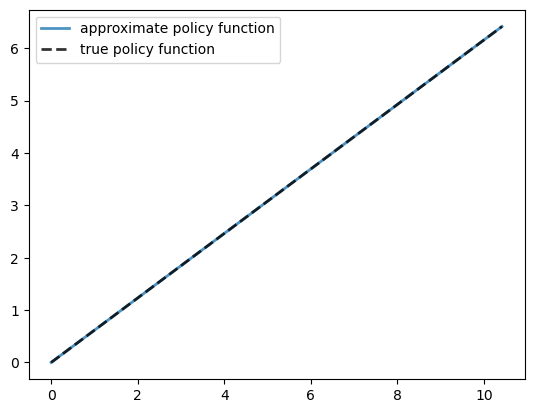

In [8]:
fig, ax = plt.subplots()

ax.plot(x, c, lw=2,
        alpha=0.8, label='approximate policy function')

ax.plot(x, σ_star(x, model.α, model.β), 'k--',
        lw=2, alpha=0.8, label='true policy function')

ax.legend()
plt.show()

The maximal absolute deviation between the two policies is

In [9]:
np.max(np.abs(c - σ_star(x, model.α, model.β)))

np.float64(2.2564941266622895e-06)

Here's the execution time:

In [10]:
with qe.Timer():
    c, x = solve_model_time_iter(model, c_init, x_init, verbose=False)

0.06 seconds elapsed


EGM is faster than time iteration because it avoids numerical root-finding.

Instead, we invert the marginal utility function directly, which is much more efficient.

In the {doc}`next lecture <cake_eating_egm_jax>`, we will use a fully vectorized
and efficient version of EGM that is also parallelized using JAX.

This provides an extremely fast way to solve the optimal consumption problem we
have been studying for the last few lectures.